## Imports

In [1]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd

## Load test instance 

In [2]:
myinst = "./artGalleryTestInstances/rooms.csv"

instance_file = myinst
instance_size  = 100
num_cells = instance_size * instance_size # total number of cells in the grid

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls
walls = np.zeros(instance_size * instance_size)

with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for line in csv_reader:
        column = int(line[0])
        row = int(line[1])
        oneD_index = (row * instance_size) + column
        walls[oneD_index] = 1

## Executables wrappers

In [3]:
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

## Individual initialisation

In [4]:
max_cameras = 300
compressed_grid_size = 50
compressed_cells = compressed_grid_size * compressed_grid_size
full_grid_size = 100
full_grid_cells = full_grid_size * full_grid_size

def generate_individual():
    nb_cam = random.randint(1, max_cameras)
    individual = np.zeros(compressed_cells)
    # select which positions should have cameras
    indexes = random.sample(range(0, compressed_cells), nb_cam)
    for j in indexes:
        individual[j] = 1

    full_solution = convert_compressed_to_full(individual)

    if len(cameras_on_walls(full_solution)) > 0:
        repair_solution(full_solution)
        individual = convert_full_to_compressed(full_solution)

    return individual

def convert_compressed_to_full(individual):
    solution = [0] * full_grid_cells

    for i in range(len(individual)):
        if individual[i] == 1:
            # Determine the row and column in the compressed grid
            row_compressed = i // compressed_grid_size
            col_compressed = i % compressed_grid_size
            
            # Calculate the top-left index of the corresponding 2x2 block in the full grid
            top_left_index = (row_compressed * 2 * full_grid_size) + (col_compressed * 2)
            
            # Set the top-left cell in the 2x2 block
            solution[top_left_index] = 1

    return solution

def convert_full_to_compressed(solution):
    individual = []
    
    # Iterate through 2x2 blocks
    for i in range(0, full_grid_size, 2):  # Rows
        for j in range(0, full_grid_size, 2):  # Columns
            # Calculate indices of the 2x2 block
            top_left = i * full_grid_size + j
            top_right = top_left + 1
            bottom_left = top_left + full_grid_size
            bottom_right = bottom_left + 1
            
            # Determine the compressed value for this block
            if (
                solution[top_left] == 1 or
                solution[top_right] == 1 or
                solution[bottom_left] == 1 or
                solution[bottom_right] == 1
            ):
                individual.append(1)
            else:
                individual.append(0)
    
    return individual


## Repair function

In [5]:
def cameras_on_walls(solution):
    positions = []
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i] == 1):
            positions.append(i)
            
    return(positions)

# delete all cameras that are on the walls 
def repair_solution(solution):
    clash_positions = cameras_on_walls(solution)

    for pos in clash_positions:
        solution[pos] = 0

def add_single_camera(individual):
    position = random.randint(0, compressed_cells)
    individual[position] = 1

## Custom mutation


In [6]:
def get_cell_neighbours(individual, cell):
    neighbours = []
    row = cell // 50
    col = cell % 50

    for row_change in [-1, 0, 1]:
        for col_change in [-1, 0, 1]:
            neighbour_row = row + row_change
            neighbour_col = col + col_change

            if 0 <= neighbour_row < 50 and 0 <= neighbour_col < 50:
                neighbour_index = neighbour_row * 50 + neighbour_col
                if individual[neighbour_index] == 1:
                    neighbours.append(neighbour_index)

    return neighbours

def remove_neighbouring_cameras(individual, neighbours: list):
    if neighbours:
        to_keep = random.choice(neighbours)
        neighbours.remove(to_keep)
        for cell in neighbours:
            if random.random() < 0.7:
                individual[cell] = 0


def neighbourhood_mutation(individual):
    for cell in range(len(individual)):
        if individual[cell] == 1:
            neighbours = get_cell_neighbours(individual, cell)
            remove_neighbouring_cameras(individual, neighbours)

    return individual,

## Evaluation function

In [7]:
def eval_function(individual):
    solution = []
    total_cameras = 99999
    fitness = total_cameras

    # convert individual to the solution list - this depends on the representation
    solution = convert_compressed_to_full(individual)

    # make sure there's at least one camera
    if sum(solution) < 1:
        add_single_camera(individual)
    
    # check if cameras on walls
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 

    if cameras_on_walls > 0:
        repair_solution(solution)
        individual = convert_full_to_compressed(solution)

    total_cameras = np.sum(solution)

    not_covered_penalty_factor = 15000

    # only call this if the solution is not invalid
    coverage = objective_function(solution, instance_size, total_cameras, instance_file)

    if coverage < 0.99:
        fitness = not_covered_penalty_factor  
    else:
        fitness = total_cameras 

    return fitness,

## Setup the EA

In [8]:
# SETUP THE EA
# define the fitness class and creare an individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# create a toolbox
toolbox = base.Toolbox()

toolbox.register("individual", lambda: creator.Individual(generate_individual()))

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", neighbourhood_mutation)
toolbox.register("select", tools.selTournament, tournsize=2)

## Main EA definition

In [9]:
population = 50
generations = 50
def main():
    
    # choose a population size: e.g. 200
    pop = toolbox.population(n=population)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(1)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.05, ngen=generations, stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

## Run the EA

In [10]:
runs = [["Best", "Generation", "Time"]]
for run in range(0, 10):
    start = time.time()
    pop, log, hof = main()
    stop = time.time()

    run_time = stop - start

    best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list

    # look in the logbook to see what generation this was found at
    min = log.select("min")  # max fitness per generation stored in log

    for i in range(generations):  # set to ngen
            fit = min[i]
            if fit == best:
                break        

    runs.append([best, i, run_time])  

    with open("output.csv", mode = "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([best,i, run_time])      
    
    print("min fitness found is %s at generation %s" % (best, i))



gen	nevals	avg    	std   	min	max  
0  	50    	2551.78	5433.2	52 	15000
1  	25    	736.1  	2912.01	52 	15000
2  	28    	126.04 	39.6752	53 	261  
3  	38    	407.6  	2084.71	53 	15000
4  	29    	98.88  	17.063 	54 	144  
5  	31    	683.14 	2922.45	54 	15000
6  	20    	378.68 	2088.79	57 	15000
7  	28    	74.78  	8.94268	57 	99   
8  	32    	367.26 	2090.4 	57 	15000
9  	29    	364.62 	2090.78	56 	15000
10 	31    	1257.12	4052.56	52 	15000
11 	28    	59.58  	3.73679	52 	68   
12 	33    	356.24 	2091.97	50 	15000
13 	36    	55.68  	2.77445	50 	64   
14 	34    	54.1   	2.59422	48 	60   
15 	30    	351.7  	2092.62	47 	15000
16 	36    	649.4  	2929.3 	45 	15000
17 	36    	648.54 	2929.48	41 	15000
18 	24    	49.08  	3.199  	40 	55   
19 	33    	347.02 	2093.28	43 	15000
20 	25    	46.64  	2.30443	42 	53   
21 	30    	45.34  	2.15044	41 	51   
22 	24    	44.54  	1.83532	42 	48   
23 	31    	342.26 	2093.96	40 	15000
24 	23    	341.46 	2094.08	40 	15000
25 	32    	41.7   	1.08167	39 	44   
26 

## Visualise solution and statistics

46
1.0
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

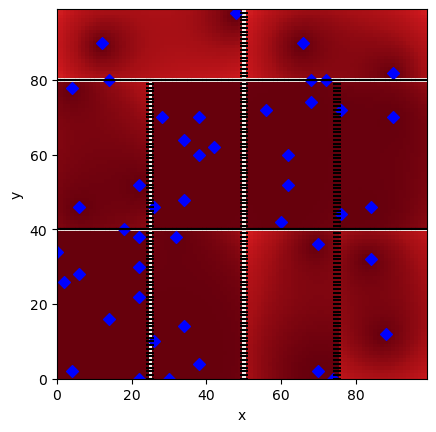

In [11]:
# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like

final_solution = hof[0]
final_solution = convert_compressed_to_full(final_solution)

actual_cameras=sum(final_solution)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid
print(actual_cameras)
coverage = objective_function(final_solution, instance_size, actual_cameras, instance_file)
print(coverage)
cameras_on_walls = check_walls(final_solution, instance_file) 
print(cameras_on_walls)
print(final_solution)


# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")

# choose a layout


visualise_objective_function(final_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


C:\Users\julka\AppData\Local\Temp\ipykernel_4972\2919038694.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
C:\Users\julka\AppData\Local\Temp\ipykernel_4972\2919038694.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
C:\Users\julka\AppData\Local\Temp\ipykernel_4972\2919038694.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")


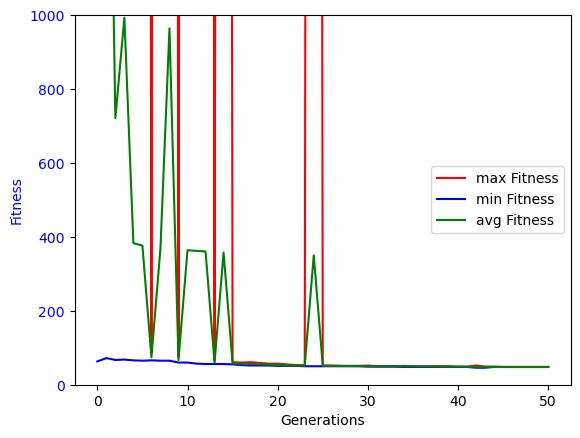

In [12]:
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
ax1.set_ylim(0,1000)
    
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")
